# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

**Признаки**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**

- Price — цена (евро)

## Подготовка данных

In [1]:
#Импортируем необходимые библиотеки
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Откроем и изучим датафрейм
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
#Изучим общую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
#Приведём столбцы к нижнему и змеиному регистрам
df = df.rename(columns = {'DateCrawled': 'date_crawled', 'Price': 'price', 'VehicleType': 'vehicle_type', 'RegistrationYear':
                         'registration_year', 'Gearbox': 'gearbox', 'Power': 'power', 'Model': 'model', 'Kilometer': 
                          'kilometer', 'RegistrationMonth': 'registration_month', 'FuelType': 'fuel_type', 'Brand': 'brand',
                         'NotRepaired': 'not_repaired', 'DateCreated': 'date_created', 'NumberOfPictures': 
                          'number_of_pictures', 'PostalCode': 'postal_code', 'LastSeen': 'last_seen'})

In [5]:
#Проверим изменения
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [6]:
#Заменим тип данных в столбцах с датами на им соответствующий
df['date_crawled'] = df['date_crawled'].astype('datetime64')
df['date_created'] = df['date_created'].astype('datetime64')
df['last_seen'] = df['last_seen'].astype('datetime64')

In [7]:
#Посмотрим количество пропусков в столбцах нашего датафрейма
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [8]:
#Выведем уникальные значения столбцов с пропусками
print('Уникальные значения типа автомобильного кузова:', df['vehicle_type'].unique())
print()
print('Уникальные значения типа коробки передач:', df['gearbox'].unique())
print()
print('Уникальные значения модели автомобиля:', df['model'].unique())
print()
print('Уникальные значения типа топлива:', df['fuel_type'].unique())
print()
print('Уникальные значения столбца not_repaired:', df['not_repaired'].unique())

Уникальные значения типа автомобильного кузова: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

Уникальные значения типа коробки передач: ['manual' 'auto' nan]

Уникальные значения модели автомобиля: ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octav

In [9]:
#Заполним пропуски в 3 столбцах на 'other'
df['vehicle_type'] = df['vehicle_type'].fillna('other')
df['model'] = df['model'].fillna('other')
df['fuel_type'] = df['fuel_type'].fillna('other')

In [10]:
#Поскольку в столбцах 'gearbox' и 'not_repaired' присутствуют 2 значения (не считая пропусков), и эти значения мы не знаем, чем 
#заполнить, поскольку при заполнении клиенты могли оставить их пустыми, можно удалить строки, которые имеют в этих значениях 
#пропуск
df = df.dropna() 

In [11]:
#Проверим изменения
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276170 entries, 1 to 354367
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        276170 non-null  datetime64[ns]
 1   price               276170 non-null  int64         
 2   vehicle_type        276170 non-null  object        
 3   registration_year   276170 non-null  int64         
 4   gearbox             276170 non-null  object        
 5   power               276170 non-null  int64         
 6   model               276170 non-null  object        
 7   kilometer           276170 non-null  int64         
 8   registration_month  276170 non-null  int64         
 9   fuel_type           276170 non-null  object        
 10  brand               276170 non-null  object        
 11  not_repaired        276170 non-null  object        
 12  date_created        276170 non-null  datetime64[ns]
 13  number_of_pictures  276170 no

In [12]:
#Проверим количество дублирующихся строк
df.duplicated().sum()

4

In [13]:
#Удалим дублирующиеся строки
df = df.drop_duplicates()

In [14]:
#Проверим изменения
df.duplicated().sum()

0

In [15]:
#Изучим данные на возможные выбросы
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,276166.000000,276166.000000,276166.000000,276166.000000,276166.000000,276166.0,276166.000000
mean,4908.733620,2003.439348,118.131178,127685.287110,6.050843,0.0,51068.847997
std,4670.008341,25.306359,169.628710,37170.861383,3.548716,0.0,25869.378566
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1340.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30635.500000
50%,3200.000000,2003.000000,109.000000,150000.000000,6.000000,0.0,50169.000000
75%,7000.000000,2008.000000,150.000000,150000.000000,9.000000,0.0,72070.000000
max,20000.000000,9000.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


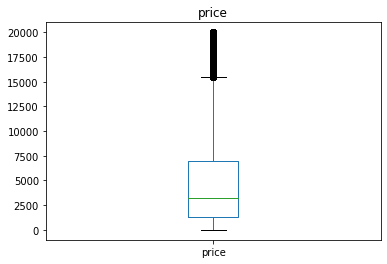

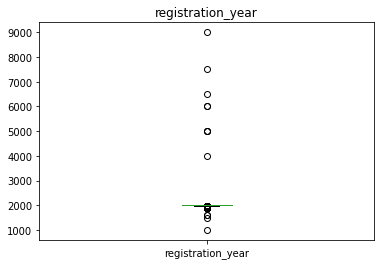

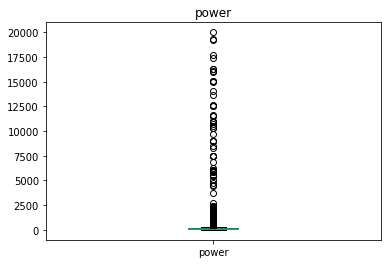

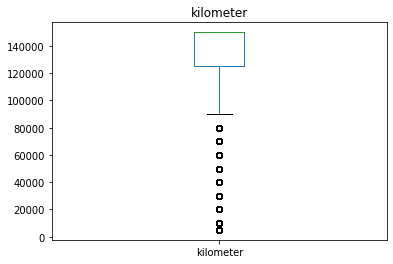

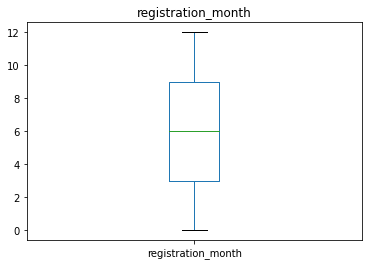

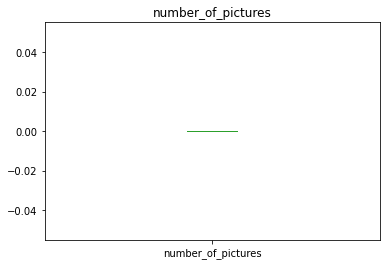

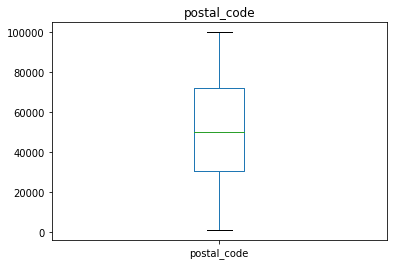

In [16]:
#Построим графики для выбранных данных для изучения выбросов
for col in ['price', 'registration_year', 'power', 'kilometer', 'registration_month', 'number_of_pictures', 'postal_code']:
    df[col].plot.box()
    plt.title(col)
    plt.show()

<AxesSubplot:>

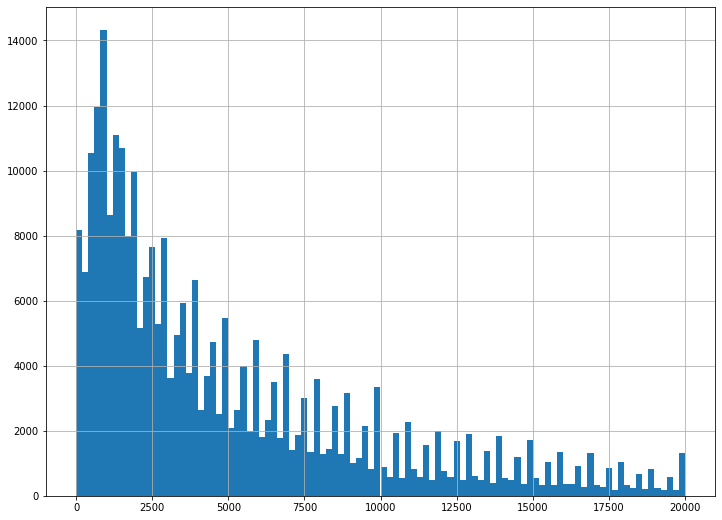

In [17]:
#Построим гистограмму для столбца 'price'
df['price'].hist(bins=100, figsize=(12,9))

<AxesSubplot:>

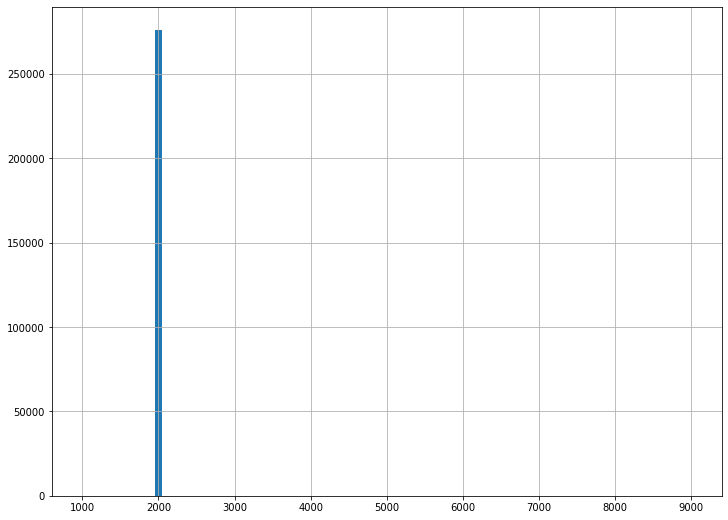

In [18]:
#Построим гистограмму для столбца 'registration_year'
df['registration_year'].hist(bins=100, figsize=(12,9))

<AxesSubplot:>

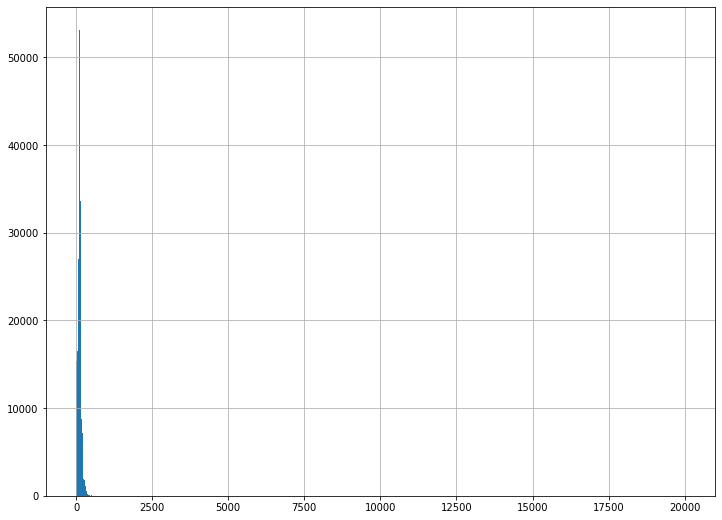

In [19]:
#Построим гистограмму для столбца 'power'
df['power'].hist(bins=1000, figsize=(12,9))

In [20]:
#Узнаем дату последнего скачивания анкеты с базы для понимания того, какого максимального года выпуска была машина
df['date_crawled'].max()

Timestamp('2016-04-07 14:36:58')

In [21]:
#По полученным данным отсеим все выбросы в нашем датафрейме
df = df.query('1989 < registration_year < 2017 and 50 < power < 200 and 1000 < price < 7500')

In [22]:
#Посмотрим корреляционную зависимость между признаками
print('Зависимость цены от года регистрации автомобиля:', df['price'].corr(df['registration_year']))
print('Зависимость цены от мощности:', df['price'].corr(df['power']))
print('Зависимость цены от пробега:', df['price'].corr(df['kilometer']))

Зависимость цены от года регистрации автомобиля: 0.5229579321013164
Зависимость цены от мощности: 0.22896635063210746
Зависимость цены от пробега: -0.2622137220094236


### Вывод

Значения были изучены, данные приведены в порядок: 
- пропуски были заполнены по возможности, либо удалены;
- дубликаты были удалены;
- названия столбцов были приведены к нижнему и змеиному регистрам;
- у столбцов с датами были изменены с типами данных на соответствующий датам;
- аномальные выбросы были изучены и отсеяны;

## Обучение моделей

In [23]:
#Выделим отдельно день, месяц и год из столбца 'date_created'
df['weekday'] = df['date_created'].dt.weekday
df['month'] = df['date_created'].dt.month
df['year'] = df['date_created'].dt.year

In [24]:
#Создадим новый датафрейм и удалим из него ненужные столбцы
new_df = df.drop(['date_crawled', 'last_seen', 'date_created', 'registration_month', 'number_of_pictures', 
                  'postal_code'], axis=1)

In [25]:
#Выделим категории из нового датафрейма, который имеют тип 'object' и добавим к нему столбцы дня, месяца и года
categorical = new_df.select_dtypes(include='object').columns.to_list() + ['weekday', 'month', 'year']

In [26]:
#Применим LabelEncoder к столбцам из категорий
encoder = LabelEncoder()
for col in categorical:
    new_df[col] = encoder.fit_transform(new_df[col])

In [27]:
#Выделим признаки и обучающую с тестовой выборки
X = new_df.drop('price', axis=1)
y = new_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

In [28]:
%%time
#Проверим модель LightGBM и её скорость обучения
parameters_lgbm = {'max_depth':[1, 30], 'learning_rate':[0.1, 0.25, 0.5],
                'random_state':[12345], 'class_weight': ['balanced', None]}
model_lgbm = LGBMRegressor()
grid_lgbm = GridSearchCV(estimator=model_lgbm, param_grid=parameters_lgbm, cv=5)
grid_lgbm.fit(X_train, y_train)

CPU times: user 2min 45s, sys: 1.1 s, total: 2min 46s
Wall time: 2min 48s


GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'class_weight': ['balanced', None],
                         'learning_rate': [0.1, 0.25, 0.5],
                         'max_depth': [1, 30], 'random_state': [12345]})

In [29]:
%%time
#Проверим скорость предсказания модели LightGBM
expected_y  = y_test
predicted_y = grid_lgbm.predict(X_test)

CPU times: user 162 ms, sys: 15.9 ms, total: 178 ms
Wall time: 193 ms


In [30]:
#Проверим качество предсказания RMSE модели LightGBM
print(mean_squared_error(expected_y, predicted_y)**(.5))

894.6824600662313


In [31]:
%%time
#Проверим модель LinearRegression и её скорость обучения
parameters_LR = {'normalize':[True,False], 'fit_intercept':[True,False]}
model_LR = LinearRegression()
grid_LR = GridSearchCV(estimator=model_LR, param_grid=parameters_LR, cv=5)
grid_LR.fit(X_train, y_train)

CPU times: user 2.2 s, sys: 1.88 s, total: 4.08 s
Wall time: 4.1 s


GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]})

In [32]:
%%time
#Проверим скорость предсказания модели LinearRegression
expected_y  = y_test
predicted_y = grid_LR.predict(X_test)

CPU times: user 30.2 ms, sys: 12.8 ms, total: 42.9 ms
Wall time: 78.8 ms


In [33]:
#Проверим качество предсказания RMSE модели LinearRegression
print(mean_squared_error(expected_y, predicted_y)**(.5))

1300.8710926964172


In [34]:
%%time
#Проверим модель RandomForestRegressor и её скорость обучения
parameters_RFR = {'n_estimators':[1, 100], 'max_depth':[1, 30], 
                  'random_state':[12345]}
model_RFR = RandomForestRegressor()
grid_RFR = GridSearchCV(estimator=model_RFR, param_grid=parameters_RFR, cv=5)
grid_RFR.fit(X_train, y_train)

CPU times: user 2min 15s, sys: 1.31 s, total: 2min 16s
Wall time: 2min 17s


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 30], 'n_estimators': [1, 100],
                         'random_state': [12345]})

In [35]:
%%time
#Проверим скорость предсказания модели RandomForestRegressor
expected_y  = y_test
predicted_y = grid_RFR.predict(X_test)

CPU times: user 997 ms, sys: 0 ns, total: 997 ms
Wall time: 1.01 s


In [36]:
#Проверим качество предсказания RMSE модели RandomForestRegressor
print(mean_squared_error(expected_y, predicted_y)**(.5))

920.8894277185415


In [37]:
%%time
#Проверим модель DecisionTreeRegressor и её скорость обучения
parameters_DTR = {'max_depth':[1,30], 'random_state':[12345]}
model_DTR = DecisionTreeRegressor()
grid_DTR = GridSearchCV(estimator=model_DTR, param_grid=parameters_DTR, cv=5)
grid_DTR.fit(X_train, y_train)

CPU times: user 2.05 s, sys: 11.5 ms, total: 2.06 s
Wall time: 2.07 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 30], 'random_state': [12345]})

In [38]:
%%time
#Проверим скорость предсказания модели DecisionTreeRegressor
expected_y  = y_test
predicted_y = grid_DTR.predict(X_test)

CPU times: user 14.5 ms, sys: 0 ns, total: 14.5 ms
Wall time: 13.1 ms


In [39]:
#Проверим качество предсказания RMSE модели DecisionTreeRegressor
print(mean_squared_error(expected_y, predicted_y)**(.5))

1149.2700995657676


### Вывод

Были обучены различные модели с параметрами, также было оценено качество предсказаний RMSE этих моделей.

## Анализ моделей

In [40]:
#Запишем получившиеся значения
data = [['5min 45s', '115 ms', 894],
        ['4.05 s', '2.88 ms', 1300],
        ['2min 27s', '1.06 s', 920],
        ['2.24 s', '14.6 ms', 1149]]
models = ['LightGBM', 'LinearRegression', 'RandomForestRegressor', 'DecisionTreeRegressor']

In [41]:
#Выведем значения в виде датафрейма
pd.DataFrame(data=data, index=models, columns=['Время обучения', 'Скорость предсказания', 'Качество предсказания RMSE'])

,Время обучения,Скорость предсказания,Качество предсказания RMSE
LightGBM,5min 45s,115 ms,894
LinearRegression,4.05 s,2.88 ms,1300
RandomForestRegressor,2min 27s,1.06 s,920
DecisionTreeRegressor,2.24 s,14.6 ms,1149


### Вывод

Таким образом, мы видим, что самой лучшей по качеству предсказания оказалась модель LightGBM, самой худшей - модель LinearRegression. При этом, по времени обучения LightGBM является самой долгой, а самой быстрой - модель DecisionTreeRegressor.

## Общий вывод

Были взяты и обучены модели LightGBM, LinearRegression, RandomForestRegressor, DecisionTreeRegressor, данные приведены в порядок. 

Несмотря на то, что модель LightGBM обладает наилучшим качеством, она дольше всего обучается. Модель LinearRegression имеет одно из самых быстрых время обучения и скорость предсказания, но качество предсказания RMSE самое низкое из всех 4. Модель RandomForestRegressor имеет чуть меньше время обучения по сравнению с моделью LightGBM, но качество предсказания RMSE чуть хуже. Модель DesicionTreeRegressor имеет низкое время обучения и скорость предсказания, но качество предсказания будет похуже, чем у модели RandomForestRegressor.

**ИТОГ: Среди 4 моделей самыми лучшими является модели DecisionTreeRegressor и RandomForestRegressor:**
- RandomForestRegressor имеет относительно долгое время обучения, при этом оно меньше, чем у LightGBM, а их качество предсказания практически совпадают;
- DecisionTreeRegressor имеет быстрое время обучения, но его качество хуже, чем у LightGBM и RandomForestRegressor, хотя и не такое, как у LinearRegression;
